# Sensitivity Analysis

Performing pressure sensitivity analysis...
Analyzing pressure: 0.3 atm


C:\Users\Damia\AppData\Local\Temp\ipykernel_6740\2517654972.py:222: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(equations, guess, xtol=1e-12)


Analyzing pressure: 0.4 atm
Analyzing pressure: 0.5 atm
Analyzing pressure: 0.6 atm
Analyzing pressure: 0.7 atm
Analyzing pressure: 0.8 atm
Analyzing pressure: 0.9 atm
Analyzing pressure: 1.0 atm
Analyzing pressure: 1.1 atm
Analyzing pressure: 1.2 atm
Analyzing pressure: 1.3 atm
Analyzing pressure: 1.4 atm
Analyzing pressure: 1.5 atm
Analyzing pressure: 1.6 atm
Analyzing pressure: 1.7 atm
Analyzing pressure: 1.8 atm
Analyzing pressure: 1.9 atm
Analyzing pressure: 2.0 atm
Analyzing pressure: 2.1 atm
Analyzing pressure: 2.2 atm
Analyzing pressure: 2.3 atm
Analyzing pressure: 2.4 atm
Analyzing pressure: 2.5 atm
Analyzing pressure: 2.6 atm
Analyzing pressure: 2.7 atm
Analyzing pressure: 2.8 atm
Analyzing pressure: 2.9 atm
Analyzing pressure: 3.0 atm
Analyzing pressure: 3.1 atm
Analyzing pressure: 3.2 atm
Analyzing pressure: 3.3 atm
Analyzing pressure: 3.4 atm
Analyzing pressure: 3.5 atm
Analyzing pressure: 3.6 atm
Analyzing pressure: 3.7 atm
Analyzing pressure: 3.8 atm
Analyzing pressure: 

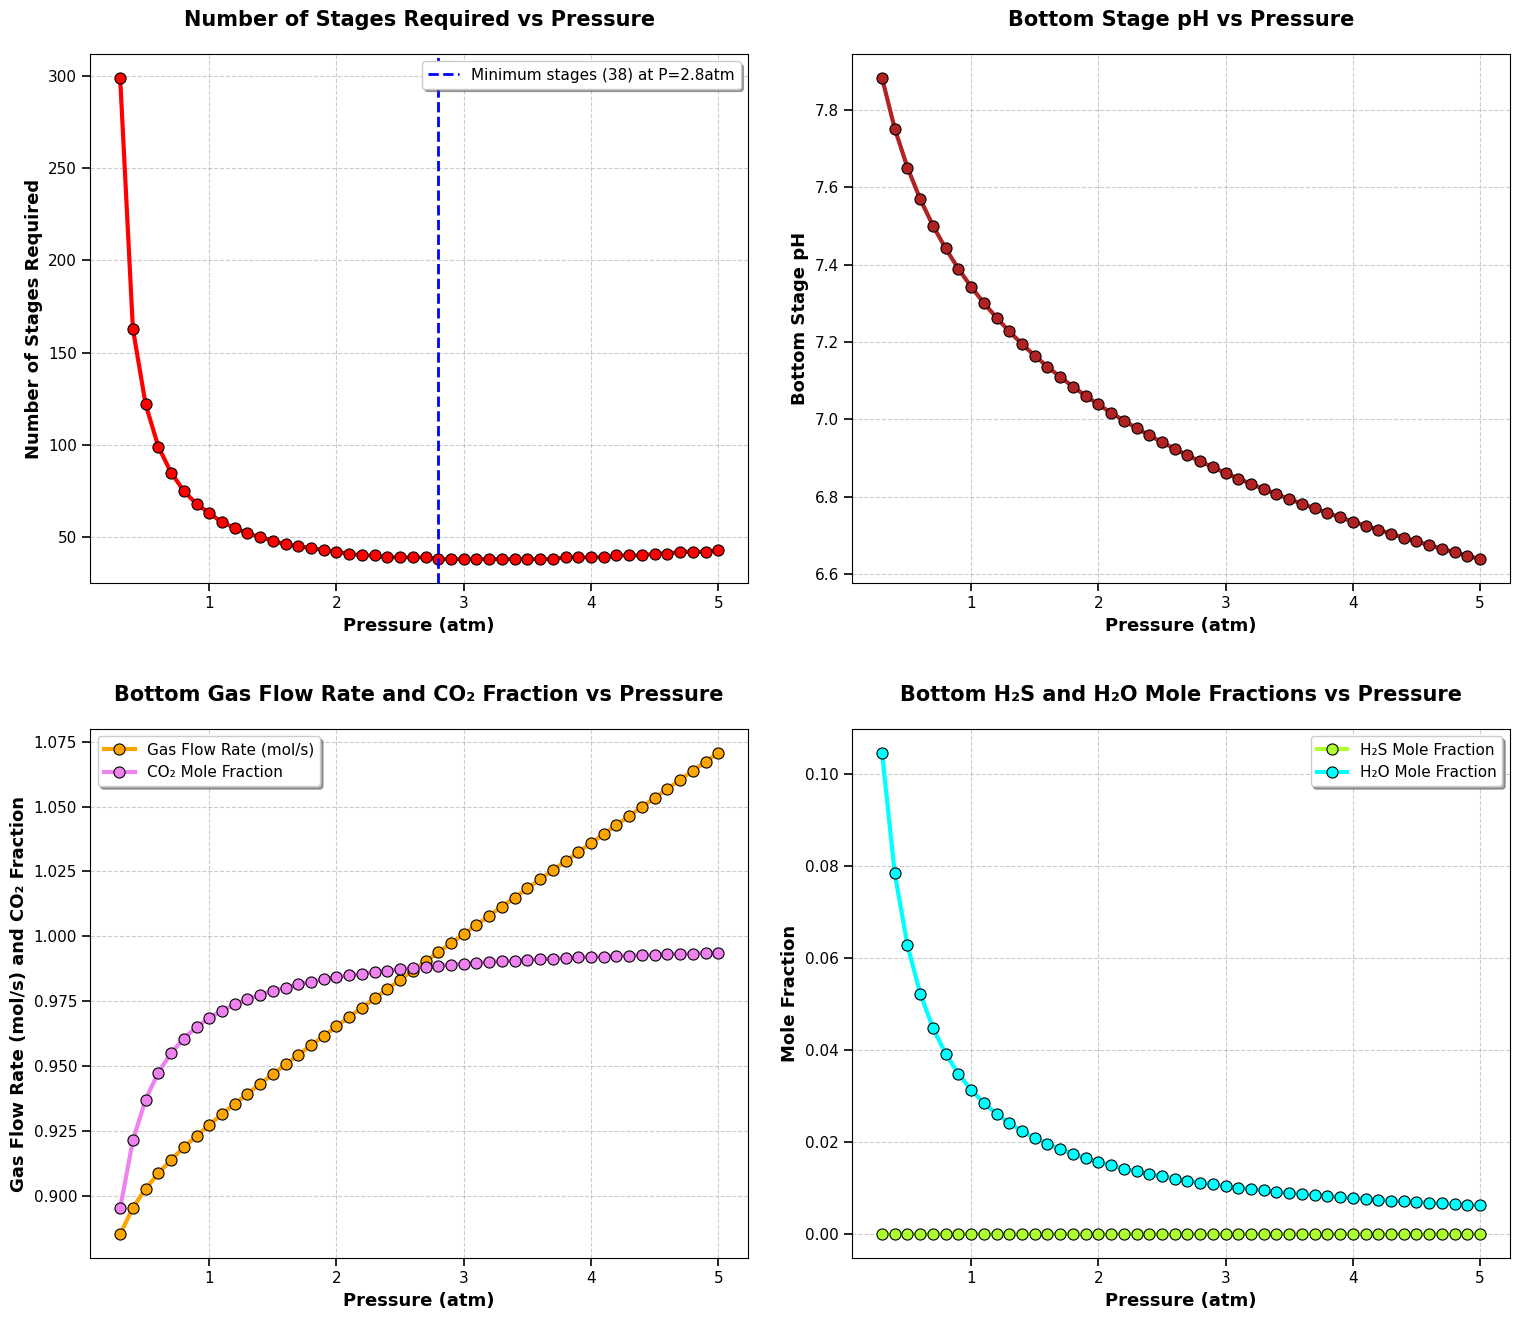

In [45]:
from scipy.optimize import fsolve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================================
# PRESSURE SENSITIVITY ANALYSIS FOR STRIPPING COLUMN
# =============================================================================================
# Pressure range for sensitivity analysis
pressure_range = np.arange(0.3, 5.1, 0.1)  # 0.3 atm to 5.0 atm in 0.1 atm increments
# =============================================================================================

# Base operating conditions
T_operating = 25        # °C
V_stage = 180           # L
L_flow = 1              # L/s
G_flow_out_top = 0.9    # mol/s (from top of column)
ε_gas_fraction = 5      # %
d_bubble_mm = 5         # mm
x_H2S_recovery = 99.99  # %
max_stages = 1000       # Maximum number of stages

# Feed concentrations (at the top of column)
c_NaHS_feed = 0.8        # mol/L
c_CO2_feed = 0           # mol/L
c_H2CO3_feed = 0         # mol/L
c_HCO3_feed = 0          # mol/L
c_CO3_feed = 0           # mol/L
c_H2S_feed = 0           # mol/L
c_S_feed = 0             # mol/L

# Equilibrium constants and property functions (temperature-dependent, fixed at 25°C)
def K_eq(T):
    K_eq = 1/(0.04020944211255422*(np.e**(0.2130531302959603*T)) + 838.3007987989027)
    return K_eq

def K_1c(T):
    K_1c = 10**(-0.994 - (610.5/(T + 273.15)))
    return K_1c

def K_2c(T):
    K_2c = 10**(452.094 - (21263.61/(T + 273.15)) - (68.483143*np.log((T + 273.15))))
    return K_2c

def K_1s(T):
    K_1s = 10**(-32.55 - (1519.44/(T + 273.15)) + (15.672*np.log10((T + 273.15))) - (0.02722*(T + 273.15)))
    return K_1s

def K_2s(T):
    K_2s = 10**(-(4500/(T + 273.15)) - (12.6*np.log10((T + 273.15)/298.15)) + 1.29)
    return K_2s

def K_w(T):
    K_w = 10**(-(142613.6/(T + 273.15)) - (4229.195*np.log10((T + 273.15))) + (9.7384*(T + 273.15)) - (0.0129638*(T + 273.15)**2) + (1.15068e-5 *(T + 273.15)**3) - (4.602e-9 *(T + 273.15)**4) + 8909.483)
    return K_w

def k_f(T):
    k_f = np.e**(22.66 - (7799/(T + 273.15)))
    return k_f

# Physical property functions (temperature-dependent, fixed at 25°C)
d_bubble_m = d_bubble_mm/1000
a = (6*(ε_gas_fraction/100))/d_bubble_m
g = 9.182
MM_H2O = 18.01528

def liquid_surface_tension(T):
    factor = (647.15 - (T + 273.15))/647.15
    σ_L = (235.8e-3)*(1 - 0.625*factor)*(factor**1.256)
    return σ_L

def liquid_density(T):
    ρ_L = -13.851 + (0.64038*(T + 273.15)) - (0.0019124*((T + 273.15)**2)) + ((1.8211e-6)*((T + 273.15)**3))
    return ρ_L*(MM_H2O/1000)*(10**3)

def liquid_dynamic_viscosity(T):
    μ_L = np.e**(-52.843 + (3703.6/(T + 273.15)) + (5.866*np.log(T + 273.15)) - ((5.879e-29)*((T + 273.15)**10)))
    return μ_L

def bubble_rising_velocity(T):
    σ_L = liquid_surface_tension(T)
    ρ_L = liquid_density(T)
    u_b = (((2.14*σ_L)/(d_bubble_m*ρ_L)) + (0.505*g*d_bubble_m))**0.5
    return u_b

def liquid_diffusivity_CO2(T):
    D_L_25_CO2 = (1.96e-5)/(100**2)
    μ_L_25 = liquid_dynamic_viscosity(25)
    constant_25_CO2 = D_L_25_CO2*μ_L_25/(25 + 273.15)
    D_L_CO2 = constant_25_CO2*(T + 273.15)/liquid_dynamic_viscosity(T)
    return D_L_CO2

def liquid_side_mass_transfer_coefficient_CO2(T):
    k_L_CO2 = 2*((liquid_diffusivity_CO2(T)*bubble_rising_velocity(T))/(np.pi*d_bubble_m))**0.5
    return k_L_CO2

def k_La_CO2_func(T):
    k_La_CO2 = a*liquid_side_mass_transfer_coefficient_CO2(T)
    return k_La_CO2

def liquid_diffusivity_H2S(T):
    D_L_25_H2S = (1.61e-5)/(100**2)
    μ_L_25 = liquid_dynamic_viscosity(25)
    constant_25_H2S = D_L_25_H2S*μ_L_25/(25 + 273.15)
    D_L_H2S = constant_25_H2S*(T + 273.15)/liquid_dynamic_viscosity(T)
    return D_L_H2S

def liquid_side_mass_transfer_coefficient_H2S(T):
    k_L_H2S = 2*((liquid_diffusivity_H2S(T)*bubble_rising_velocity(T))/(np.pi*d_bubble_m))**0.5
    return k_L_H2S

def k_La_H2S_func(T):
    k_La_H2S = a*liquid_side_mass_transfer_coefficient_H2S(T)
    return k_La_H2S

def P_vap_H2O(T):
    A_H2O = 4.6543
    B_H2O = 1435.264
    C_H2O = -64.848
    P_vap_H2O = 10**(A_H2O - (B_H2O / ((T + 273.15) + C_H2O)))
    return P_vap_H2O * 0.986923

def k_H_CO2(T):
    k_H_CO2_start = 0.034*np.e**(2600*((1/(T + 273.15)) - (1/298.15)))
    k_H_CO2 = k_H_CO2_start*liquid_density(T)*(1.01325/1000)
    return k_H_CO2

def k_H_H2S(T):
    k_H_H2S_start = 0.1*np.e**(2300*((1/(T + 273.15)) - (1/298.15)))
    k_H_H2S = k_H_H2S_start*liquid_density(T)*(1.01325/1000)
    return k_H_H2S

def solve_stage(liquid_in, gas_out, stage_num, T_op, P_op):
    """
    Solve a single stage given liquid inlet and gas outlet conditions
    P_op is the operating pressure in atm
    """
    # Calculate temperature-dependent constants (fixed at 25°C)
    K_eq_val = K_eq(T_op)
    K_1c_val = K_1c(T_op)
    K_2c_val = K_2c(T_op)
    K_1s_val = K_1s(T_op)
    K_2s_val = K_2s(T_op)
    K_w_val = K_w(T_op)
    k_f_val = k_f(T_op)
    k_La_CO2 = k_La_CO2_func(T_op)
    k_La_H2S = k_La_H2S_func(T_op)
    k_H_CO2_val = k_H_CO2(T_op)
    k_H_H2S_val = k_H_H2S(T_op)
    
    # Extract input conditions
    c_Na_in = liquid_in['Na']
    c_H2S_in = liquid_in['H2S']
    c_HS_in = liquid_in['HS']
    c_S_in = liquid_in['S']
    c_CO2_in = liquid_in['CO2']
    c_H2CO3_in = liquid_in['H2CO3']
    c_HCO3_in = liquid_in['HCO3']
    c_CO3_in = liquid_in['CO3']
    
    G_flow_out = gas_out['flow']
    y_H2O_out = gas_out['H2O']
    y_H2S_out = gas_out['H2S']
    y_CO2_out = gas_out['CO2']
    
    # Calculate interfacial concentrations (pressure-dependent)
    c_H2S_i_stage = k_H_H2S_val * y_H2S_out * P_op
    c_CO2_i_stage = k_H_CO2_val * y_CO2_out * P_op
    
    # Sodium is conserved
    c_Na_out = c_Na_in
    
    # Define equations for this stage with transformed variables
    def equations(vars):
        pH, y_scaled, z_scaled = vars  # pH, 1000*c_H2CO3_out, 1000*c_H2S_out
        
        # Convert back to actual concentrations
        c_H_out = 10**(-pH)
        c_H2CO3_out = y_scaled / 1000.0
        c_H2S_out = z_scaled / 1000.0
        
        # Calculate other concentrations
        c_OH_out = K_w_val / c_H_out
        c_HCO3_out = c_H2CO3_out * K_1c_val / c_H_out
        c_CO3_out = c_HCO3_out * K_2c_val / c_H_out
        c_HS_out = c_H2S_out * K_1s_val / c_H_out
        c_S_out = c_HS_out * K_2s_val / c_H_out

        c_CO2_out = ((L_flow*(c_H2CO3_out + c_HCO3_out + c_CO3_out) - L_flow*(c_H2CO3_in + c_HCO3_in + c_CO3_in)) /
                     (k_f_val*(1 - ε_gas_fraction/100)*V_stage)) + (c_H2CO3_out/K_eq_val)

        term2 = k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out) + k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out)
        G_flow_in = G_flow_out + (term2/(1 - y_H2O_out))

        y_H2S_in = ((G_flow_out*y_H2S_out) + (k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out))) / G_flow_in
        y_CO2_in = ((G_flow_out*y_CO2_out) + (k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out))) / G_flow_in

        eq1 = c_Na_out + c_H_out - c_HCO3_out - 2*c_CO3_out - c_OH_out - c_HS_out - 2*c_S_out
        eq2 = (G_flow_out*y_CO2_out + L_flow*(c_CO2_out + c_H2CO3_out + c_HCO3_out + c_CO3_out) -
               G_flow_in*y_CO2_in - L_flow*(c_CO2_in + c_H2CO3_in + c_HCO3_in + c_CO3_in))
        eq3 = (G_flow_out*y_H2S_out + L_flow*(c_H2S_out + c_HS_out + c_S_out) -
               G_flow_in*y_H2S_in - L_flow*(c_H2S_in + c_HS_in + c_S_in))

        return [eq1, eq2, eq3]

    # Try multiple initial guesses with transformed variables
    initial_guesses = [
        [7.0, 1.0, 1.0],      # pH=7, 1000*[H2CO3]=1, 1000*[H2S]=1
        [6.8, 1.2, 1.0],      # pH=6.8, 1000*[H2CO3]=1.2, 1000*[H2S]=1
        [7.2, 0.8, 1.0],      # pH=7.2, 1000*[H2CO3]=0.8, 1000*[H2S]=1
        [7.0, 1.0, 1.2],      # pH=7, 1000*[H2CO3]=1, 1000*[H2S]=1.2
        [7.0, 1.0, 0.8],      # pH=7, 1000*[H2CO3]=1, 1000*[H2S]=0.8
        [6.5, 1.5, 1.5],      # pH=6.5, 1000*[H2CO3]=1.5, 1000*[H2S]=1.5
        [7.5, 0.5, 0.5],      # pH=7.5, 1000*[H2CO3]=0.5, 1000*[H2S]=0.5
    ]
    
    best_solution = None
    best_residual = 1e10

    for guess in initial_guesses:
        try:
            solution = fsolve(equations, guess, xtol=1e-12)
            residual_vals = equations(solution)
            residual = sum([r**2 for r in residual_vals])
            
            # Check if solution is physically reasonable
            pH_val, y_scaled_val, z_scaled_val = solution
            c_H_val = 10**(-pH_val)
            c_H2CO3_val = y_scaled_val / 1000.0
            c_H2S_val = z_scaled_val / 1000.0
            
            # Physical constraints
            if (4 <= pH_val <= 14 and c_H2CO3_val > 0 and c_H2S_val > 0 and 
                y_scaled_val > 0 and z_scaled_val > 0 and residual < best_residual):
                best_residual = residual
                best_solution = solution
        except:
            continue

    if best_solution is None:
        raise ValueError(f"Could not converge stage {stage_num} at T = {T_op}°C, P = {P_op} atm")

    # Extract solution and convert back to actual concentrations
    pH_out, y_scaled_out, z_scaled_out = best_solution
    c_H_out = 10**(-pH_out)
    c_H2CO3_out = y_scaled_out / 1000.0
    c_H2S_out = z_scaled_out / 1000.0
    
    # Calculate derived concentrations
    c_OH_out = K_w_val / c_H_out
    c_HCO3_out = c_H2CO3_out * K_1c_val / c_H_out
    c_CO3_out = c_HCO3_out * K_2c_val / c_H_out
    c_HS_out = c_H2S_out * K_1s_val / c_H_out
    c_S_out = c_HS_out * K_2s_val / c_H_out
    
    c_CO2_out = ((L_flow*(c_H2CO3_out + c_HCO3_out + c_CO3_out) - L_flow*(c_H2CO3_in + c_HCO3_in + c_CO3_in)) /
                 (k_f_val*(1 - ε_gas_fraction/100)*V_stage)) + (c_H2CO3_out/K_eq_val)
    
    term2 = k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out) + k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out)
    G_flow_in = G_flow_out + (term2/(1 - y_H2O_out))
    
    y_H2S_in = ((G_flow_out*y_H2S_out) + (k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out))) / G_flow_in
    y_CO2_in = ((G_flow_out*y_CO2_out) + (k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out))) / G_flow_in
    y_H2O_in = y_H2O_out
    
    # Package outputs
    liquid_out = {
        'Na': c_Na_out,
        'H': c_H_out,
        'OH': c_OH_out,
        'CO2': c_CO2_out,
        'H2CO3': c_H2CO3_out,
        'HCO3': c_HCO3_out,
        'CO3': c_CO3_out,
        'H2S': c_H2S_out,
        'HS': c_HS_out,
        'S': c_S_out,
        'pH': pH_out
    }
    
    gas_in = {
        'flow': G_flow_in,
        'H2O': y_H2O_in,
        'CO2': y_CO2_in,
        'H2S': y_H2S_in
    }
    
    return liquid_out, gas_in, best_residual

def simulate_column_at_pressure(P_operating):
    """
    Simulate the stripping column at a given pressure (at fixed temperature of 25°C)
    Returns: number of stages, final pH, bottom gas properties
    """
    
    # Initialize liquid feed at top (stage 1)
    liquid_feed = {
        'Na': c_NaHS_feed,
        'H2S': c_H2S_feed,
        'HS': c_NaHS_feed,  # Initial HS- from NaHS feed
        'S': c_S_feed,
        'CO2': c_CO2_feed,
        'H2CO3': c_H2CO3_feed,
        'HCO3': c_HCO3_feed,
        'CO3': c_CO3_feed
    }

    # Initialize gas outlet from top (stage 1) - pressure dependent
    P_vap_H2O_val = P_vap_H2O(T_operating)
    y_H2O_top = P_vap_H2O_val/P_operating  # This changes with pressure!
    y_H2S_top = ((x_H2S_recovery/100)*c_NaHS_feed*L_flow)/G_flow_out_top
    y_CO2_top = 1 - y_H2O_top - y_H2S_top

    gas_top = {
        'flow': G_flow_out_top,
        'H2O': y_H2O_top,
        'CO2': y_CO2_top,
        'H2S': y_H2S_top
    }

    # Calculate target sulphur remaining in liquid
    total_sulphur_feed = c_NaHS_feed
    target_sulphur_remaining = total_sulphur_feed * (1 - x_H2S_recovery/100)

    # Solve column from top to bottom
    current_liquid = liquid_feed.copy()
    current_gas = gas_top.copy()

    converged = False
    final_stage = 0
    previous_total_sulphur = None
    final_liquid_out = None
    final_gas_in = None

    for stage in range(1, max_stages + 1):
        try:
            liquid_out, gas_in, residual = solve_stage(current_liquid, current_gas, stage, T_operating, P_operating)
            
            # Calculate sulphur mass balance for this stage
            total_sulphur_out = liquid_out['H2S'] + liquid_out['HS'] + liquid_out['S']
            
            # Check if we should stop BEFORE reaching the target
            if previous_total_sulphur is not None:
                # If current stage would go below target, stop at previous stage
                if total_sulphur_out <= target_sulphur_remaining:
                    converged = True
                    final_stage = stage - 1
                    break
            
            # Store current results
            final_liquid_out = liquid_out.copy()
            final_gas_in = gas_in.copy()
            
            # Store current sulphur content for next iteration
            previous_total_sulphur = total_sulphur_out
            
            # Update for next stage
            current_liquid = liquid_out.copy()
            current_gas = gas_in.copy()
            
        except Exception as e:
            print(f"Error at P={P_operating} atm, stage {stage}: {e}")
            break

    if not converged and final_stage == 0:
        final_stage = len(range(1, stage))
        
    return final_stage, final_liquid_out, final_gas_in

# Perform pressure sensitivity analysis
print("Performing pressure sensitivity analysis...")
print("="*80)

results = []
failed_pressures = []

for P in pressure_range:
    print(f"Analyzing pressure: {P:.1f} atm")
    try:
        n_stages, final_liquid, final_gas = simulate_column_at_pressure(P)
        
        if final_liquid is not None and final_gas is not None:
            results.append({
                'Pressure': P,
                'Stages': n_stages,
                'Final_pH': final_liquid['pH'],
                'Bottom_Gas_Flow': final_gas['flow'],
                'Bottom_CO2_Fraction': final_gas['CO2'],
                'Bottom_H2S_Fraction': final_gas['H2S'],
                'Bottom_H2O_Fraction': final_gas['H2O']
            })
        else:
            failed_pressures.append(P)
            print(f"  Failed to converge at {P:.1f} atm")
    except Exception as e:
        failed_pressures.append(P)
        print(f"  Failed at {P:.1f} atm: {e}")

# Convert results to DataFrame
df_results = pd.DataFrame(results)

if len(df_results) == 0:
    print("No successful simulations!")
else:
    print(f"\nSuccessfully analyzed {len(df_results)} pressures")
    print(f"Failed pressures: {failed_pressures}")
    
    # Create sensitivity analysis plots
    plt.style.use('default')

    # Set figure parameters
    plt.rcParams.update({
        'figure.figsize': [16, 14],
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'legend.fontsize': 11,
        'lines.linewidth': 2.5,
        'lines.markersize': 8
    })

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))

    # Plot 1: Number of stages vs pressure
    ax1.plot(df_results['Pressure'], df_results['Stages'], 'o-', 
             linewidth=3, markersize=8, color='red', markerfacecolor='red', 
             markeredgecolor='black', markeredgewidth=0.8)

    # Add vertical dashed line at pressure with minimum stages
    min_stage = df_results['Stages'].min()
    i = df_results['Stages'].idxmin()
    P_min = pressure_range[i]
    message = 'Minimum stages ('+str(min_stage)+') at P='+str(round(P_min, 2))+'atm'
    ax1.axvline(x=pressure_range[i], color='blue', linestyle='--', linewidth=2, label=message)

    ax1.set_xlabel('Pressure (atm)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Number of Stages Required', fontsize=13, fontweight='bold')
    ax1.set_title('Number of Stages Required vs Pressure', fontsize=15, fontweight='bold', pad=20)
    ax1.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=11)
    ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
    ax1.tick_params(axis='both', which='major', labelsize=11, width=1.2, length=6)

    # Plot 2: Final pH vs pressure
    ax2.plot(df_results['Pressure'], df_results['Final_pH'], 'o-', 
             linewidth=3, markersize=8, color='firebrick', markerfacecolor='firebrick',
             markeredgecolor='black', markeredgewidth=0.8)
    ax2.set_xlabel('Pressure (atm)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Bottom Stage pH', fontsize=13, fontweight='bold')
    ax2.set_title('Bottom Stage pH vs Pressure', fontsize=15, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
    ax2.tick_params(axis='both', which='major', labelsize=11, width=1.2, length=6)

    # Plot 3: Bottom gas flow and CO2 fraction vs pressure
    line1 = ax3.plot(df_results['Pressure'], df_results['Bottom_Gas_Flow'], 'o-', 
                     linewidth=3, markersize=8, label='Gas Flow Rate (mol/s)', color='orange',
                     markerfacecolor='orange', markeredgecolor='black', markeredgewidth=0.8)
    line2 = ax3.plot(df_results['Pressure'], df_results['Bottom_CO2_Fraction'], 'o-', 
                     linewidth=3, markersize=8, label='CO₂ Mole Fraction', color='violet',
                     markerfacecolor='violet', markeredgecolor='black', markeredgewidth=0.8)
    ax3.set_xlabel('Pressure (atm)', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Gas Flow Rate (mol/s) and CO₂ Fraction', fontsize=13, fontweight='bold')
    ax3.set_title('Bottom Gas Flow Rate and CO₂ Fraction vs Pressure', 
                  fontsize=15, fontweight='bold', pad=20)
    ax3.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=11)
    ax3.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
    ax3.tick_params(axis='both', which='major', labelsize=11, width=1.2, length=6)

    # Plot 4: Bottom H2S and H2O fractions vs pressure
    ax4.plot(df_results['Pressure'], df_results['Bottom_H2S_Fraction'], 'o-', 
             linewidth=3, markersize=8, label='H₂S Mole Fraction', color='greenyellow',
             markerfacecolor='greenyellow', markeredgecolor='black', markeredgewidth=0.8)
    ax4.plot(df_results['Pressure'], df_results['Bottom_H2O_Fraction'], 'o-', 
             linewidth=3, markersize=8, label='H₂O Mole Fraction', color='cyan',
             markerfacecolor='cyan', markeredgecolor='black', markeredgewidth=0.8)
    ax4.set_xlabel('Pressure (atm)', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Mole Fraction', fontsize=13, fontweight='bold')
    ax4.set_title('Bottom H₂S and H₂O Mole Fractions vs Pressure', 
                  fontsize=15, fontweight='bold', pad=20)
    ax4.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=11)
    ax4.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
    ax4.tick_params(axis='both', which='major', labelsize=11, width=1.2, length=6)

    # Adjust layout spacing
    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=2.0)
    plt.show()

# Empirical Plot for Number of Stages Required vs Pressure

1st Degree Polynomial: R² = 0.288201
2nd Degree Polynomial: R² = 0.584832
3rd Degree Polynomial: R² = 0.750629
4th Degree Polynomial: R² = 0.852095
Exponential Function: R² = 0.973531
Exponential Decay With Offset: R² = 0.980287
Exponential With Power: R² = 0.535654
Simple Logarithmic: R² = 0.561313
Complex Logarithmic: R² = 0.832916
Power Law With Offset: R² = 0.994516
Power Law With Exponential: R² = 0.995405
Simple Rational Function: R² = 0.995362
Complex Rational Function: R² = 0.998933


C:\Users\Damia\AppData\Local\Temp\ipykernel_6740\892869412.py:16: RuntimeWarning: overflow encountered in power
  def exponential_power(x, a, b, c, d): return a * np.exp(b * x**c) + d
C:\Users\Damia\AppData\Local\Temp\ipykernel_6740\892869412.py:16: RuntimeWarning: overflow encountered in exp
  def exponential_power(x, a, b, c, d): return a * np.exp(b * x**c) + d
C:\Users\Damia\AppData\Local\Temp\ipykernel_6740\892869412.py:49: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, P_data, stages_data, p0=initial_guess, maxfev=10000)


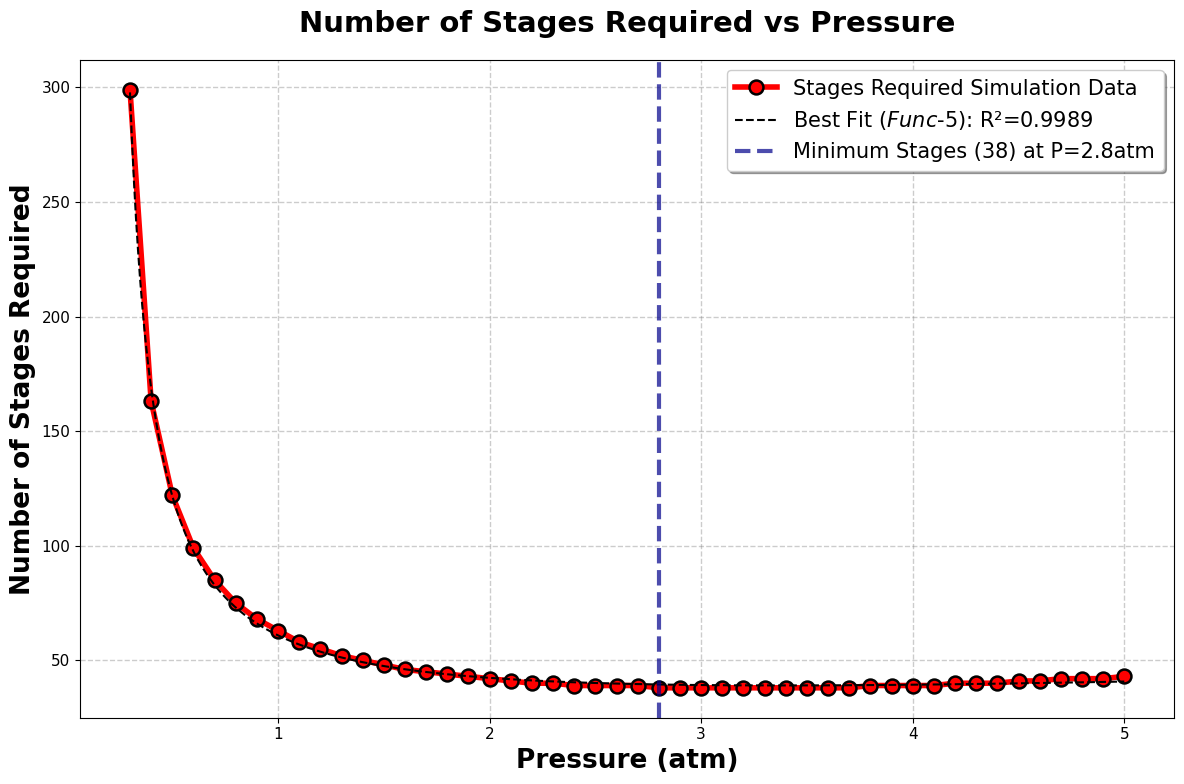


Best Parametric Fit: Complex Rational Function
R² = 0.998933
Best Parametric Form: Stages = (a*P² + b*P + c) / (P² + d*P + e)
Parameters:
   a = 2.528515e+07
   b = 1.442412e+08
   c = 2.313810e+08
   d = 8.078881e+06
   e = -1.493799e+06


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract data from results
P_data = df_results['Pressure'].values
stages_data = df_results['Stages'].values

# Define multiple fitting functions
def polynomial_1st(x, a, b): return a * x + b
def polynomial_2nd(x, a, b, c): return a * x**2 + b * x + c
def polynomial_3rd(x, a, b, c, d): return a * x**3 + b * x**2 + c * x + d
def polynomial_4th(x, a, b, c, d, e): return a * x**4 + b * x**3 + c * x**2 + d * x + e
def exponential_fit(x, a, b, c): return a * np.exp(b * x) + c
def exponential_decay(x, a, b, c, d): return a * np.exp(-b * x) + c * x + d
def exponential_power(x, a, b, c, d): return a * np.exp(b * x**c) + d
def logarithmic_simple(x, a, b): return a * np.log(x) + b
def logarithmic_complex(x, a, b, c): return a * np.log(x) + b * x + c
def power_law(x, a, b, c): return a * x**b + c
def power_exponential(x, a, b, c, d): return a * x**b * np.exp(c * x) + d
def rational_simple(x, a, b, c): return (a * x + b) / (x + c)
def rational_complex(x, a, b, c, d, e): return (a * x**2 + b * x + c) / (x**2 + d * x + e)

# List of functions to try
fitting_functions = [
    (polynomial_1st, "1st Degree Polynomial", [1, 1]),
    (polynomial_2nd, "2nd Degree Polynomial", [1, 1, 1]),
    (polynomial_3rd, "3rd Degree Polynomial", [1, 1, 1, 1]),
    (polynomial_4th, "4th Degree Polynomial", [1, 1, 1, 1, 1]),
    (exponential_fit, "Exponential Function", [1, -0.01, 1]),
    (exponential_decay, "Exponential Decay With Offset", [1, 0.01, 0.1, 1]),
    (exponential_power, "Exponential With Power", [1, -0.01, 1, 1]),
    (logarithmic_simple, "Simple Logarithmic", [1, 1]),
    (logarithmic_complex, "Complex Logarithmic", [1, 1, 1]),
    (power_law, "Power Law With Offset", [1, -1, 1]),
    (power_exponential, "Power Law With Exponential", [1, 1, 0.01, 1]),
    (rational_simple, "Simple Rational Function", [1, 1, 1]),
    (rational_complex, "Complex Rational Function", [1, 1, 1, 1, 1])
]

# Fit models
best_fit = None
best_r2 = -np.inf
best_name = ""
best_params = None

for func, name, initial_guess in fitting_functions:
    try:
        popt, _ = curve_fit(func, P_data, stages_data, p0=initial_guess, maxfev=10000)
        y_pred = func(P_data, *popt)

        # R² calculation
        ss_res = np.sum((stages_data - y_pred) ** 2)
        ss_tot = np.sum((stages_data - np.mean(stages_data)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        print(f"{name}: R² = {r2:.6f}")

        if r2 > best_r2:
            best_r2 = r2
            best_fit = func
            best_name = name
            best_params = popt

    except Exception as e:
        print(f"Failed to fit {name}: {e}")

# Plot results
P_fine = np.linspace(P_data.min(), P_data.max(), 1000)

plt.figure(figsize=(12, 8))
plt.plot(P_data, stages_data, 'o-', linewidth=4, markersize=10,
         color='red', markerfacecolor='red', markeredgecolor='black',
         markeredgewidth=1.8, label='Stages Required Simulation Data')

if best_fit is not None:
    y_fit = best_fit(P_fine, *best_params)
    plt.plot(P_fine, y_fit, '--', linewidth=1.5, color='black',
             label = rf"Best Fit ($\it{{Func\text{{-}}5}}$): R²={best_r2:.4f}")

# Vertical line at minimum
min_idx = np.argmin(stages_data)
plt.axvline(x=P_data[min_idx], color='darkblue', linestyle='--', linewidth=3,
           alpha=0.7, label=f'Minimum Stages ({stages_data[min_idx]}) at P={round(P_data[min_idx],1)}atm')

plt.xlabel('Pressure (atm)', fontsize=19, fontweight='bold')
plt.ylabel('Number of Stages Required', fontsize=19, fontweight='bold')
plt.title('Number of Stages Required vs Pressure', fontsize=21, fontweight='bold', pad=20)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=15)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1, color='grey')
plt.tight_layout()
plt.show()

# Print best fitting summary
if best_fit is not None:
    print(f"\nBest Parametric Fit: {best_name}")
    print(f"R² = {best_r2:.6f}")

    # Map function names to their equations
    function_forms = {
        "1st Degree Polynomial": "Stages = a*P + b",
        "2nd Degree Polynomial": "Stages = a*P² + b*P + c",
        "3rd Degree Polynomial": "Stages = a*P³ + b*P² + c*P + d",
        "4th Degree Polynomial": "Stages = a*P⁴ + b*P³ + c*P² + d*P + e",
        "Exponential Function": "Stages = a*exp(b*P) + c",
        "Exponential Decay With Offset": "Stages = a*exp(-b*P) + c*P + d",
        "Exponential With Power": "Stages = a*exp(b*P^c) + d",
        "Simple Logarithmic": "Stages = a*ln(P) + b",
        "Complex Logarithmic": "Stages = a*ln(P) + b*P + c",
        "Power Law With Offset": "Stages = a*P^b + c",
        "Power Law With Exponential": "Stages = a*P^b * exp(c*P) + d",
        "Simple Rational Function": "Stages = (a*P + b) / (P + c)",
        "Complex Rational Function": "Stages = (a*P² + b*P + c) / (P² + d*P + e)"
    }

    # Print functional form
    if best_name in function_forms:
        print(f"Best Parametric Form: {function_forms[best_name]}")
    else:
        print("Best Parametric Form: [Not defined in dictionary]")

    # Print parameters
    param_names = ["a", "b", "c", "d", "e"]
    print("Parameters:")
    for i, p in enumerate(best_params):
        print(f"   {param_names[i]} = {p:.6e}")

# Empirical Plot for Bottom Stage pH vs Pressure

1st Degree Polynomial: R² = 0.889286
2nd Degree Polynomial: R² = 0.979077
3rd Degree Polynomial: R² = 0.995108
4th Degree Polynomial: R² = 0.998721
Exponential Function: R² = 0.993369
Exponential Decay With Offset: R² = 0.999285
Failed to fit Exponential With Power: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Simple Logarithmic: R² = 0.999967
Complex Logarithmic: R² = 0.999993
Power Law With Offset: R² = 0.999998
Power Law With Exponential: R² = 0.999993
Simple Rational Function: R² = 0.997999
Complex Rational Function: R² = 0.999998


C:\Users\Damia\AppData\Local\Temp\ipykernel_6740\3775924364.py:16: RuntimeWarning: overflow encountered in exp
  def exponential_power(x, a, b, c, d): return a * np.exp(b * x**c) + d


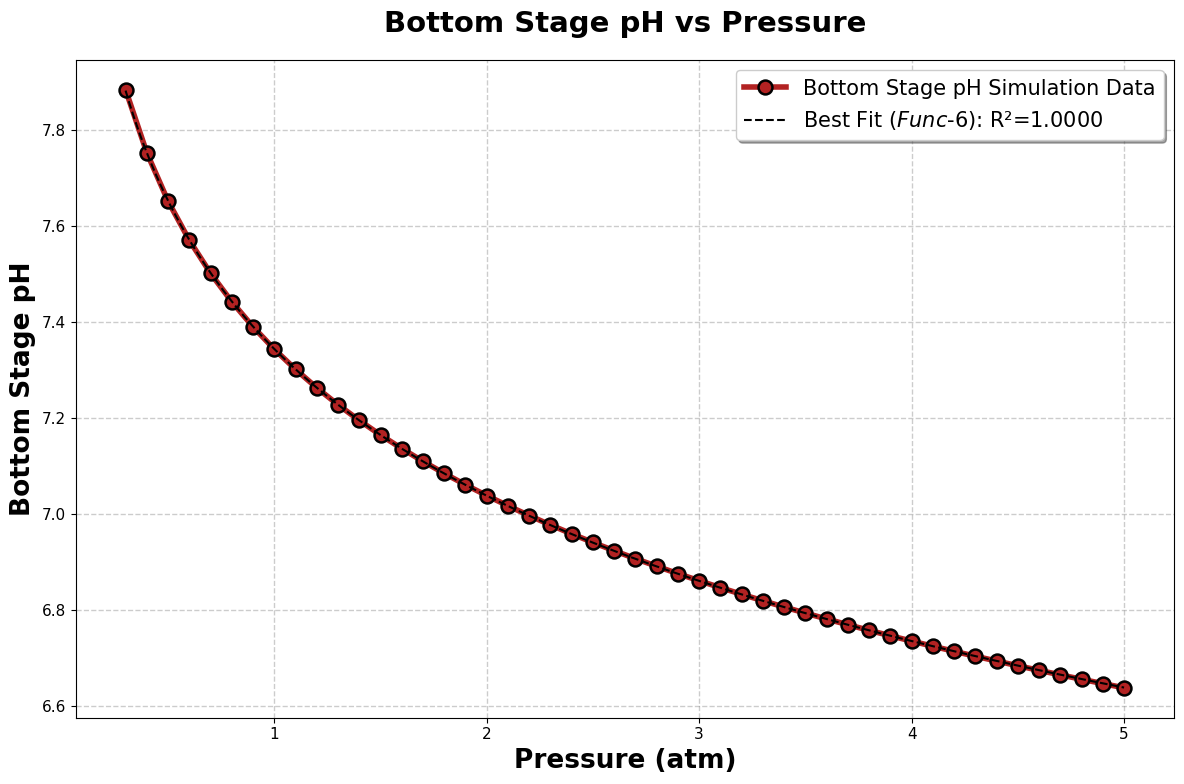


Best Parametric Fit: Power Law With Offset
R² = 0.999998
Best Parametric Form: pH = a*P^b + c
Parameters:
   a = 3.143954e+01
   b = -1.407998e-02
   c = -2.409567e+01


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract data from results
P_data = df_results['Pressure'].values
pH_data = df_results['Final_pH'].values

# Define multiple fitting functions
def polynomial_1st(x, a, b): return a * x + b
def polynomial_2nd(x, a, b, c): return a * x**2 + b * x + c
def polynomial_3rd(x, a, b, c, d): return a * x**3 + b * x**2 + c * x + d
def polynomial_4th(x, a, b, c, d, e): return a * x**4 + b * x**3 + c * x**2 + d * x + e
def exponential_fit(x, a, b, c): return a * np.exp(b * x) + c
def exponential_decay(x, a, b, c, d): return a * np.exp(-b * x) + c * x + d
def exponential_power(x, a, b, c, d): return a * np.exp(b * x**c) + d
def logarithmic_simple(x, a, b): return a * np.log(x) + b
def logarithmic_complex(x, a, b, c): return a * np.log(x) + b * x + c
def power_law(x, a, b, c): return a * x**b + c
def power_exponential(x, a, b, c, d): return a * x**b * np.exp(c * x) + d
def rational_simple(x, a, b, c): return (a * x + b) / (x + c)
def rational_complex(x, a, b, c, d, e): return (a * x**2 + b * x + c) / (x**2 + d * x + e)

# List of functions to try
fitting_functions = [
    (polynomial_1st, "1st Degree Polynomial", [1, 1]),
    (polynomial_2nd, "2nd Degree Polynomial", [1, 1, 1]),
    (polynomial_3rd, "3rd Degree Polynomial", [1, 1, 1, 1]),
    (polynomial_4th, "4th Degree Polynomial", [1, 1, 1, 1, 1]),
    (exponential_fit, "Exponential Function", [1, -0.01, 1]),
    (exponential_decay, "Exponential Decay With Offset", [1, 0.01, 0.1, 1]),
    (exponential_power, "Exponential With Power", [1, -0.01, 1, 1]),
    (logarithmic_simple, "Simple Logarithmic", [1, 1]),
    (logarithmic_complex, "Complex Logarithmic", [1, 1, 1]),
    (power_law, "Power Law With Offset", [1, -1, 1]),
    (power_exponential, "Power Law With Exponential", [1, 1, 0.01, 1]),
    (rational_simple, "Simple Rational Function", [1, 1, 1]),
    (rational_complex, "Complex Rational Function", [1, 1, 1, 1, 1])
]

# Fit models
best_fit = None
best_r2 = -np.inf
best_name = ""
best_params = None

for func, name, initial_guess in fitting_functions:
    try:
        popt, _ = curve_fit(func, P_data, pH_data, p0=initial_guess, maxfev=10000)
        y_pred = func(P_data, *popt)

        # R² calculation
        ss_res = np.sum((pH_data - y_pred) ** 2)
        ss_tot = np.sum((pH_data - np.mean(pH_data)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        print(f"{name}: R² = {r2:.6f}")

        if r2 > best_r2:
            best_r2 = r2
            best_fit = func
            best_name = name
            best_params = popt

    except Exception as e:
        print(f"Failed to fit {name}: {e}")

# Plot results
P_fine = np.linspace(P_data.min(), P_data.max(), 1000)

plt.figure(figsize=(12, 8))
plt.plot(P_data, pH_data, 'o-', linewidth=4, markersize=10,
         color='firebrick', markerfacecolor='firebrick', markeredgecolor='black',
         markeredgewidth=1.8, label='Bottom Stage pH Simulation Data')

if best_fit is not None:
    y_fit = best_fit(P_fine, *best_params)
    plt.plot(P_fine, y_fit, '--', linewidth=1.5, color='black',
             label = rf"Best Fit ($\it{{Func\text{{-}}6}}$): R²={best_r2:.4f}")

plt.xlabel('Pressure (atm)', fontsize=19, fontweight='bold')
plt.ylabel('Bottom Stage pH', fontsize=19, fontweight='bold')
plt.title('Bottom Stage pH vs Pressure', fontsize=21, fontweight='bold', pad=20)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=15)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1, color='grey')
plt.tight_layout()
plt.show()

# Best fitting summary
if best_fit is not None:
    print(f"\nBest Parametric Fit: {best_name}")
    print(f"R² = {best_r2:.6f}")

    # Map function names to their equations
    function_forms = {
        "1st Degree Polynomial": "pH = a*P + b",
        "2nd Degree Polynomial": "pH = a*P² + b*P + c",
        "3rd Degree Polynomial": "pH = a*P³ + b*P² + c*P + d",
        "4th Degree Polynomial": "pH = a*P⁴ + b*P³ + c*P² + d*P + e",
        "Exponential Function": "pH = a*exp(b*P) + c",
        "Exponential Decay With Offset": "pH = a*exp(-b*P) + c*P + d",
        "Exponential With Power": "pH = a*exp(b*P^c) + d",
        "Simple Logarithmic": "pH = a*ln(P) + b",
        "Complex Logarithmic": "pH = a*ln(P) + b*P + c",
        "Power Law With Offset": "pH = a*P^b + c",
        "Power Law With Exponential": "pH = a*P^b * exp(c*P) + d",
        "Simple Rational Function": "pH = (a*P + b) / (P + c)",
        "Complex Rational Function": "pH = (a*P² + b*P + c) / (P² + d*P + e)"
    }

    # Print functional form
    if best_name in function_forms:
        print(f"Best Parametric Form: {function_forms[best_name]}")
    else:
        print("Best Parametric Form: [Not defined in dictionary]")

    # Print parameters
    param_names = ["a", "b", "c", "d", "e"]
    print("Parameters:")
    for i, p in enumerate(best_params):
        print(f"   {param_names[i]} = {p:.6e}")

# Empirical Plot for Bottom Gas Flow Rate and CO₂ Fraction vs Pressure

Gas Flow | 1st Degree Polynomial: R² = 0.996364
Gas Flow | 2nd Degree Polynomial: R² = 0.998430
Gas Flow | 3rd Degree Polynomial: R² = 0.999337
Gas Flow | 4th Degree Polynomial: R² = 0.999725
Gas Flow | Exponential Function: R² = 0.996362
Gas Flow | Failed to fit Exponential Decay With Offset: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gas Flow | Exponential With Power: R² = 0.999156
Gas Flow | Simple Logarithmic: R² = 0.925155
Gas Flow | Complex Logarithmic: R² = 0.999678
Gas Flow | Power Law With Offset: R² = 0.925144
Gas Flow | Power Law With Exponential: R² = 0.999902
Gas Flow | Simple Rational Function: R² = 0.998560
Gas Flow | Complex Rational Function: R² = 1.000000
CO₂ Fraction | 1st Degree Polynomial: R² = 0.572964
CO₂ Fraction | 2nd Degree Polynomial: R² = 0.825122
CO₂ Fraction | 3rd Degree Polynomial: R² = 0.930129
CO₂ Fraction | 4th Degree Polynomial: R² = 0.972613
CO₂ Fraction | Exponential Function: R² = 0.572944
CO₂ Fraction | E

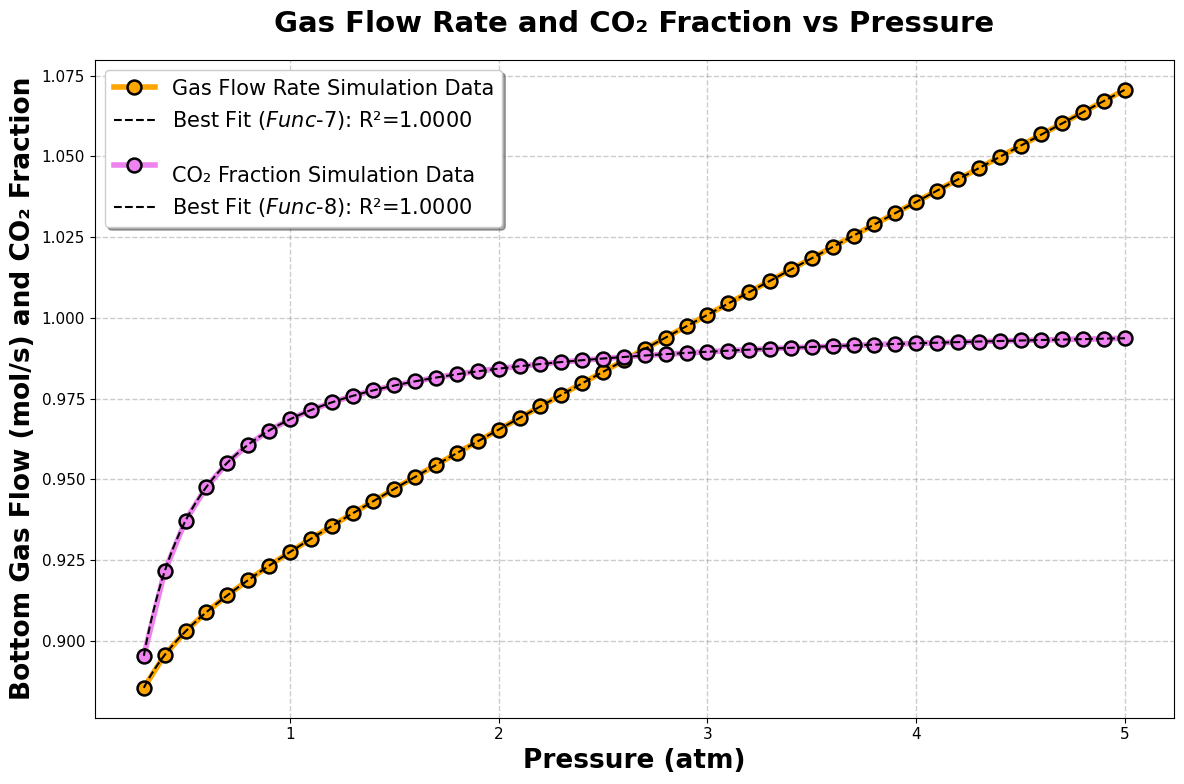


Best Parametric Fit (Gas Flow): Complex Rational Function
R² = 1.000000
Best Parametric Form: Gas Flow = (a*P² + b*P + c) / (P² + d*P + e)
Parameters:
   a = 3.686412e+02
   b = 9.603125e+03
   c = -3.750553e+02
   d = 1.068351e+04
   e = -3.376055e+02

Best Parametric Fit (CO₂ Fraction): Complex Rational Function
R² = 0.999999
Best Parametric Form: CO2 Fraction = (a*P² + b*P + c) / (P² + d*P + e)
Parameters:
   a = 9.999546e-01
   b = 2.301157e+00
   c = -7.298638e-02
   d = 2.332582e+00
   e = 2.298309e-04


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract data from results
P_data = df_results['Pressure'].values
gas_flow_data = df_results['Bottom_Gas_Flow'].values
co2_fraction_data = df_results['Bottom_CO2_Fraction'].values

# Define multiple fitting functions
def polynomial_1st(x, a, b): return a * x + b
def polynomial_2nd(x, a, b, c): return a * x**2 + b * x + c
def polynomial_3rd(x, a, b, c, d): return a * x**3 + b * x**2 + c * x + d
def polynomial_4th(x, a, b, c, d, e): return a * x**4 + b * x**3 + c * x**2 + d * x + e
def exponential_fit(x, a, b, c): return a * np.exp(b * x) + c
def exponential_decay(x, a, b, c, d): return a * np.exp(-b * x) + c * x + d
def exponential_power(x, a, b, c, d): return a * np.exp(b * x**c) + d
def logarithmic_simple(x, a, b): return a * np.log(x) + b
def logarithmic_complex(x, a, b, c): return a * np.log(x) + b * x + c
def power_law(x, a, b, c): return a * x**b + c
def power_exponential(x, a, b, c, d): return a * x**b * np.exp(c * x) + d
def rational_simple(x, a, b, c): return (a * x + b) / (x + c)
def rational_complex(x, a, b, c, d, e): return (a * x**2 + b * x + c) / (x**2 + d * x + e)

# List of functions to try
fitting_functions = [
    (polynomial_1st, "1st Degree Polynomial", [1, 1]),
    (polynomial_2nd, "2nd Degree Polynomial", [1, 1, 1]),
    (polynomial_3rd, "3rd Degree Polynomial", [1, 1, 1, 1]),
    (polynomial_4th, "4th Degree Polynomial", [1, 1, 1, 1, 1]),
    (exponential_fit, "Exponential Function", [1, -0.01, 1]),
    (exponential_decay, "Exponential Decay With Offset", [1, 0.01, 0.1, 1]),
    (exponential_power, "Exponential With Power", [1, -0.01, 1, 1]),
    (logarithmic_simple, "Simple Logarithmic", [1, 1]),
    (logarithmic_complex, "Complex Logarithmic", [1, 1, 1]),
    (power_law, "Power Law With Offset", [1, -1, 1]),
    (power_exponential, "Power Law With Exponential", [1, 1, 0.01, 1]),
    (rational_simple, "Simple Rational Function", [1, 1, 1]),
    (rational_complex, "Complex Rational Function", [1, 1, 1, 1, 1])
]

# Fit models
def fit_best_model(xdata, ydata, label):
    best_fit, best_name, best_params, best_r2 = None, "", None, -np.inf
    for func, name, guess in fitting_functions:
        try:
            popt, _ = curve_fit(func, xdata, ydata, p0=guess, maxfev=10000)
            y_pred = func(xdata, *popt)
            
            # R² calculation
            ss_res = np.sum((ydata - y_pred) ** 2)
            ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
            r2 = 1 - (ss_res / ss_tot)

            print(f"{label} | {name}: R² = {r2:.6f}")

            if r2 > best_r2:
                best_r2, best_fit, best_name, best_params = r2, func, name, popt
        except Exception as e:
            print(f"{label} | Failed to fit {name}: {e}")
    return best_fit, best_name, best_params, best_r2

# Run fits
best_fit_gas_flow, best_name_gas_flow, best_params_gas_flow, best_r2_gas_flow = fit_best_model(P_data, gas_flow_data, "Gas Flow")
best_fit_co2_fraction, best_name_co2_fraction, best_params_co2_fraction, best_r2_co2_fraction = fit_best_model(P_data, co2_fraction_data, "CO₂ Fraction")

# Plot results
P_fine = np.linspace(P_data.min(), P_data.max(), 1000)

plt.figure(figsize=(12, 8))

plt.plot(P_data, gas_flow_data, 'o-', linewidth=4, markersize=10,
         color='orange', markerfacecolor='orange', markeredgecolor='black',
         markeredgewidth=1.8, label='Gas Flow Rate Simulation Data')

if best_fit_gas_flow is not None:
    y_fit_gas_flow = best_fit_gas_flow(P_fine, *best_params_gas_flow)
    plt.plot(P_fine, y_fit_gas_flow, '--', linewidth=1.5, color='black',
             label = rf"Best Fit ($\it{{Func\text{{-}}7}}$): R²={best_r2_gas_flow:.4f}")

plt.plot(P_data, co2_fraction_data, 'o-', linewidth=4, markersize=10,
         color='violet', markerfacecolor='violet', markeredgecolor='black',
         markeredgewidth=1.8, label='\nCO₂ Fraction Simulation Data')

if best_fit_co2_fraction is not None:
    y_fit_co2_fraction = best_fit_co2_fraction(P_fine, *best_params_co2_fraction)
    plt.plot(P_fine, y_fit_co2_fraction, '--', linewidth=1.5, color='black',
             label = rf"Best Fit ($\it{{Func\text{{-}}8}}$): R²={best_r2_co2_fraction:.4f}")

plt.xlabel('Pressure (atm)', fontsize=19, fontweight='bold')
plt.ylabel('Bottom Gas Flow (mol/s) and CO₂ Fraction', fontsize=19, fontweight='bold')
plt.title('Gas Flow Rate and CO₂ Fraction vs Pressure', fontsize=21, fontweight='bold', pad=20)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=15)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1, color='grey')
plt.tight_layout()
plt.show()

# Function forms dictionary
function_forms_gas_flow = {
    "1st Degree Polynomial": "Gas Flow = a*P + b",
    "2nd Degree Polynomial": "Gas Flow = a*P² + b*P + c",
    "3rd Degree Polynomial": "Gas Flow = a*P³ + b*P² + c*P + d",
    "4th Degree Polynomial": "Gas Flow = a*P⁴ + b*P³ + c*P² + d*P + e",
    "Exponential Function": "Gas Flow = a*exp(b*P) + c",
    "Exponential Decay With Offset": "Gas Flow = a*exp(-b*P) + c*P + d",
    "Exponential With Power": "Gas Flow = a*exp(b*P^c) + d",
    "Simple Logarithmic": "Gas Flow = a*ln(P) + b",
    "Complex Logarithmic": "Gas Flow = a*ln(P) + b*P + c",
    "Power Law With Offset": "Gas Flow = a*P^b + c",
    "Power Law With Exponential": "Gas Flow = a*P^b * exp(c*P) + d",
    "Simple Rational Function": "Gas Flow = (a*P + b) / (P + c)",
    "Complex Rational Function": "Gas Flow = (a*P² + b*P + c) / (P² + d*P + e)"
}

function_forms_co2_fraction = {
    "1st Degree Polynomial": "CO2 Fraction = a*P + b",
    "2nd Degree Polynomial": "CO2 Fraction = a*P² + b*P + c",
    "3rd Degree Polynomial": "CO2 Fraction = a*P³ + b*P² + c*P + d",
    "4th Degree Polynomial": "CO2 Fraction = a*P⁴ + b*P³ + c*P² + d*P + e",
    "Exponential Function": "CO2 Fraction = a*exp(b*P) + c",
    "Exponential Decay With Offset": "CO2 Fraction = a*exp(-b*P) + c*P + d",
    "Exponential With Power": "CO2 Fraction = a*exp(b*P^c) + d",
    "Simple Logarithmic": "CO2 Fraction = a*ln(P) + b",
    "Complex Logarithmic": "CO2 Fraction = a*ln(P) + b*P + c",
    "Power Law With Offset": "CO2 Fraction = a*P^b + c",
    "Power Law With Exponential": "CO2 Fraction = a*P^b * exp(c*P) + d",
    "Simple Rational Function": "CO2 Fraction = (a*P + b) / (P + c)",
    "Complex Rational Function": "CO2 Fraction = (a*P² + b*P + c) / (P² + d*P + e)"
}

# Best fitting summary
def print_fit_summary(name, r2, params, label):
    if name is None:
        return

    print(f"\nBest Parametric Fit ({label}): {name}")
    print(f"R² = {r2:.6f}")

    # Print functional form for Gas Flow
    if label == "Gas Flow":
        if name in function_forms_gas_flow:
            print(f"Best Parametric Form: {function_forms_gas_flow[name]}")
        else:
            print("Best Parametric Form: [Not defined in dictionary]")

        # Print parameters
        param_names = ["a", "b", "c", "d", "e"]
        print("Parameters:")
        for i, p in enumerate(params):
            print(f"   {param_names[i]} = {p:.6e}")

# Print functional form for CO₂ Fraction
    if label == "CO₂ Fraction":
        if name in function_forms_co2_fraction:
            print(f"Best Parametric Form: {function_forms_co2_fraction[name]}")
        else:
            print("Best Parametric Form: [Not defined in dictionary]")

        # Print parameters
        param_names = ["a", "b", "c", "d", "e"]
        print("Parameters:")
        for i, p in enumerate(params):
            print(f"   {param_names[i]} = {p:.6e}")

# Call summaries
print_fit_summary(best_name_gas_flow, best_r2_gas_flow, best_params_gas_flow, "Gas Flow")
print_fit_summary(best_name_co2_fraction, best_r2_co2_fraction, best_params_co2_fraction, "CO₂ Fraction")

# Bottom H2S and H2O fractions vs pressure

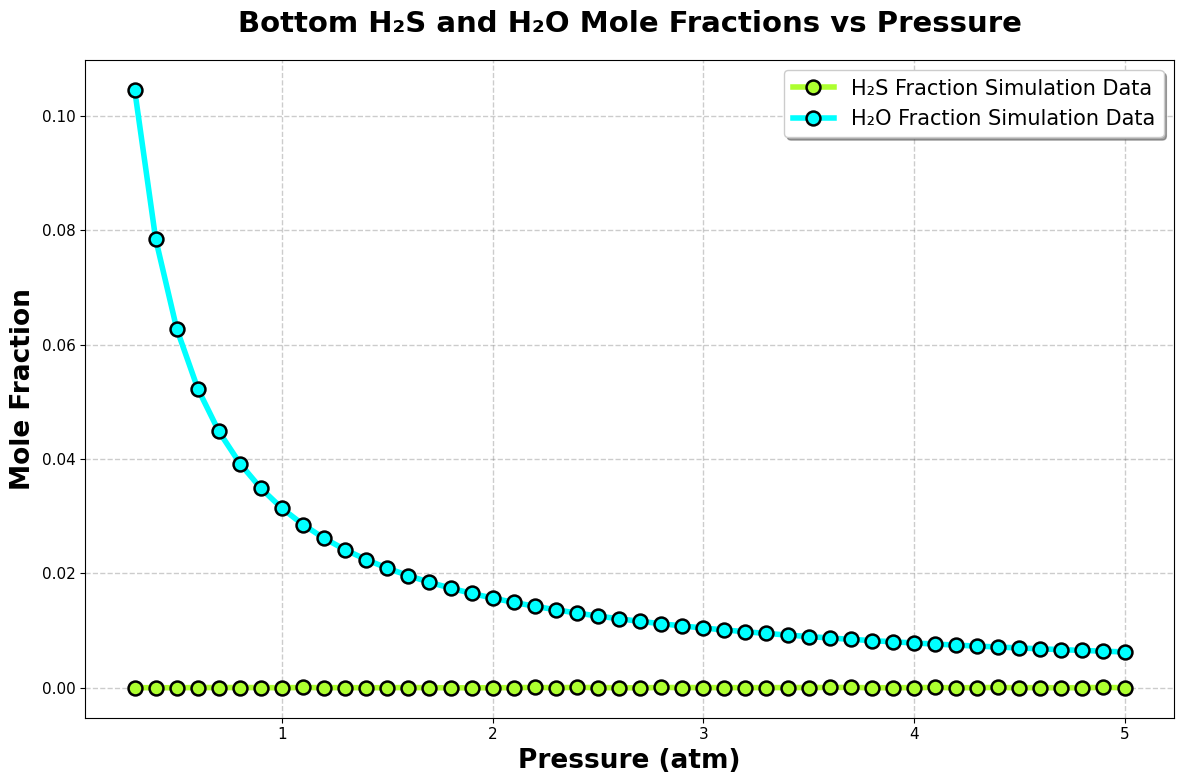

In [49]:
plt.figure(figsize=(12, 8))
plt.plot(df_results['Pressure'], df_results['Bottom_H2S_Fraction'], 'o-', 
         linewidth=4, markersize=10, label='H₂S Fraction Simulation Data', color='greenyellow',
         markerfacecolor='greenyellow', markeredgecolor='black', markeredgewidth=1.8)

plt.plot(df_results['Pressure'], df_results['Bottom_H2O_Fraction'], 'o-', 
         linewidth=4, markersize=10, label='H₂O Fraction Simulation Data', color='cyan',
         markerfacecolor='cyan', markeredgecolor='black', markeredgewidth=1.8)

plt.xlabel('Pressure (atm)', fontsize=19, fontweight='bold')
plt.ylabel('Mole Fraction', fontsize=19, fontweight='bold')
plt.title('Bottom H₂S and H₂O Mole Fractions vs Pressure', 
              fontsize=21, fontweight='bold', pad=20)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=15)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1, color='grey')

plt.tight_layout()
plt.show()